In [64]:
import numpy as np
import sklearn
import os
import pandas as pd
import typing as tp
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(rc={'figure.figsize': (8.25, 5.875), 'figure.dpi': 100, 'axes.labelpad': 2, 'savefig.pad_inches': .5})

In [3]:
from sklearn.cluster import KMeans, BisectingKMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import fowlkes_mallows_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs, load_iris, load_wine
from sklearn.preprocessing import StandardScaler

In [4]:
wine_x, wine_y = load_wine(as_frame=False, return_X_y=True)
iris_x, iris_y = load_iris(return_X_y=True)
blob_x, blob_y = make_blobs(n_samples=1_000, n_features=6, centers=10, random_state=13)

In [5]:
num_wine_classes: int = np.unique(wine_y).size
num_iris_classes: int = np.unique(iris_y).size
num_blob_classes: int = np.unique(blob_y).size

num_wine_classes, num_iris_classes, num_blob_classes

(3, 3, 10)

In [6]:
wine_x[0, :], iris_x[0, :], blob_x[0, :]
# cool all of them are numerical and thus we can use the standard deviation way.

(array([1.423e+01, 1.710e+00, 2.430e+00, 1.560e+01, 1.270e+02, 2.800e+00,
        3.060e+00, 2.800e-01, 2.290e+00, 5.640e+00, 1.040e+00, 3.920e+00,
        1.065e+03]),
 array([5.1, 3.5, 1.4, 0.2]),
 array([ 5.86486304, -9.32316688,  2.83238771,  1.99798478, -6.95136305,
        -7.61105702]))

In [7]:
def category_utility(X: np.ndarray, y_pred: np.ndarray, acuity: float = 1) -> float:
    # Page 40 of Gennari, Langley, Fisher's Models of Incremental Concept Formulation
    # recommends an acuity value of 1
    # https://www.sciencedirect.com/science/article/pii/0004370289900465?ref=cra_js_challenge&fr=RR-1
    num_clusters: int = np.unique(y_pred).size

    prob_clusters: np.ndarray = np.unique(y_pred, return_counts=True)[1] / y_pred.size
    overall_feature_std: np.ndarray = X.std(axis=0)

    overall_feature_std[np.logical_or(np.isnan(overall_feature_std),
                                  np.logical_or(np.isinf(overall_feature_std), overall_feature_std <= 0))] = acuity
    inv_overall_feature_std: np.ndarray = 1 / overall_feature_std
    inv_overall_feature_std[overall_feature_std <= acuity] = acuity

    norm: float = 1 / np.sqrt(np.pi)

    cluster_cu: np.ndarray = np.zeros((num_clusters,))

    for k in range(num_clusters):
        prob_cluster_k: float = prob_clusters[k]

        cluster_k: np.ndarray = X[y_pred == k, :]

        conditional_feature_std: np.ndarray = cluster_k.std(axis=0)

        conditional_feature_std[np.logical_or(np.isnan(conditional_feature_std),
                                          np.logical_or(np.isinf(conditional_feature_std),
                                                        conditional_feature_std <= 0))] = acuity

        inv_conditional_feature_std: np.ndarray = 1 / conditional_feature_std
        inv_conditional_feature_std[conditional_feature_std <= acuity] = acuity


        diff_std: np.ndarray = np.abs(inv_overall_feature_std - inv_conditional_feature_std)

        cluster_cu[k] = prob_cluster_k * norm * np.sum(diff_std)

    overall_category_utility: float =  1 / num_clusters * np.sum(cluster_cu)
    return overall_category_utility

In [14]:
def create_kmeans_model(num_clusters: int) -> KMeans:
    return KMeans(n_clusters=num_clusters, init='k-means++', random_state=13)

def create_spectral_model(num_clusters: int) -> SpectralClustering:
    return SpectralClustering(n_clusters=num_clusters, random_state=13, assign_labels='cluster_qr')

def create_agglomerative_model(num_clusters: int) -> AgglomerativeClustering:
    return AgglomerativeClustering(n_clusters=num_clusters)

def create_bisect_kmeans_model(num_clusters: int) -> BisectingKMeans:
    return BisectingKMeans(n_clusters=num_clusters, random_state=13, bisecting_strategy='largest_cluster')

In [16]:
MAX_CLUSTERS: int = 20

datasets: tp.List[tp.Tuple[str, int, np.ndarray, np.ndarray]] = [('Wine', num_wine_classes, wine_x, wine_y), ('Iris', num_iris_classes, iris_x, iris_y), ('Blobs', num_blob_classes, blob_x, blob_y)]

models: tp.List[tp.Tuple[str, tp.Any]] = [('K-Means++' ,create_kmeans_model), ('Spectral', create_spectral_model), ('Agglomerative', create_agglomerative_model), ('Bisecting K-Means', create_bisect_kmeans_model)]

results_dl: tp.List[tp.Dict[str, tp.Union[float, str, int]]] = []

for model_name, model_function in models:
    for dataset_name, dataset_classes, x, y in datasets:

        for k in range(2, MAX_CLUSTERS):
            model = model_function(k)

            print(f'Trying out {dataset_name} with a {model_name} model...')

            # std_scaler: StandardScaler = StandardScaler()
            # scaled_x: np.ndarray = std_scaler.fit_transform(x)

            y_pred: np.ndarray = model.fit_predict(x)

            print('Getting scores')
            fm_score: float = fowlkes_mallows_score(y, y_pred)
            db_score: float = davies_bouldin_score(x, y_pred)

            print('Getting cu')
            cu: float = category_utility(x, y_pred) #  category_utility(X_test, y_pred, k)

            results_dl.append({'model_name': model_name, 'dataset_name': dataset_name, 'num_clusters': k, 'true_num_clusters': dataset_classes, 'fowlkes_mallows_score': fm_score, 'davies_bouldin_score': db_score, 'category_utility': cu})

results_df: pd.DataFrame = pd.DataFrame.from_records(results_dl)
results_df['matches_clusters'] = results_df['num_clusters'] == results_df['true_num_clusters']
results_df

Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Gettin

/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Wine with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Wine with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site

Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site

Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral

,model_name,dataset_name,num_clusters,true_num_clusters,fowlkes_mallows_score,davies_bouldin_score,category_utility,matches_clusters
0,K-Means++,Wine,2,3,0.659051,0.478784,0.070879,False
1,K-Means++,Wine,3,3,0.583537,0.534243,0.050983,True
2,K-Means++,Wine,4,3,0.516389,0.544401,0.043712,False
3,K-Means++,Wine,5,3,0.508708,0.545047,0.037230,False
4,K-Means++,Wine,6,3,0.491180,0.465807,0.033530,False
...,...,...,...,...,...,...,...,...
211,Bisecting K-Means,Blobs,15,10,0.872394,1.692502,0.176665,False
212,Bisecting K-Means,Blobs,16,10,0.843921,1.858522,0.165894,False
213,Bisecting K-Means,Blobs,17,10,0.813559,1.968460,0.156507,False
214,Bisecting K-Means,Blobs,18,10,0.786554,2.032598,0.148226,False


In [17]:
results_df.describe()

,num_clusters,true_num_clusters,fowlkes_mallows_score,davies_bouldin_score,category_utility
count,216.000000,216.000000,216.000000,216.000000,216.000000
mean,10.500000,5.333333,0.561507,3.157390,0.087939
std,5.200179,3.307497,0.219190,10.370970,0.087163
min,2.000000,3.000000,0.194054,0.382753,0.009048
25%,6.000000,3.000000,0.395259,0.579761,0.020670
50%,10.500000,3.000000,0.538102,0.996813,0.035350
75%,15.000000,10.000000,0.754521,1.358004,0.164495
max,19.000000,10.000000,1.000000,124.197551,0.270765


In [18]:
results_df.groupby(['model_name', 'matches_clusters']).aggregate({'category_utility': ['max', 'min'], 'fowlkes_mallows_score': ['max', 'min']})

category_utility            \
                                                max       min   
model_name        matches_clusters                              
Agglomerative     False                    0.270765  0.012817   
                  True                     0.263182  0.049434   
Bisecting K-Means False                    0.263312  0.012817   
                  True                     0.263182  0.049919   
K-Means++         False                    0.270765  0.012817   
                  True                     0.263182  0.050983   
Spectral          False                    0.239577  0.009048   
                  True                     0.206275  0.022581   

                                   fowlkes_mallows_score            
                                                     max       min  
model_name        matches_clusters                                  
Agglomerative     False                         0.974514  0.258777  
                  True                          1.000000  0.582122  
Bisecting K-Means False                         0.977070  0.264654  
                  True                          1.000000  0.600405  
K-Means++         False                         0.978155  0.250735  
                  True                          1.000000  0.583537  
Spectral          False                         0.890221  0.194054  
                  True                          0.829449  0.341633

<AxesSubplot:xlabel='model_name', ylabel='category_utility'>

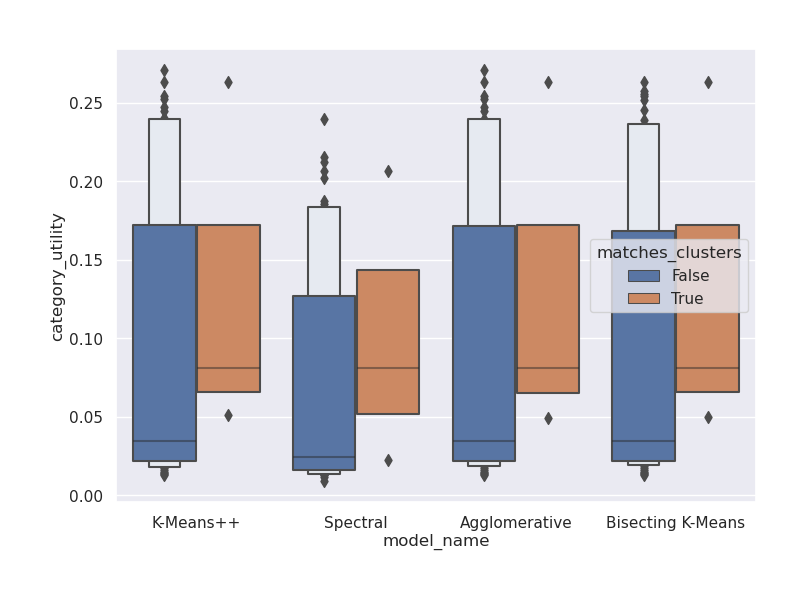

In [65]:
sns.boxenplot(data=results_df, x='model_name', y='category_utility', hue='matches_clusters')

<AxesSubplot:xlabel='model_name', ylabel='fowlkes_mallows_score'>

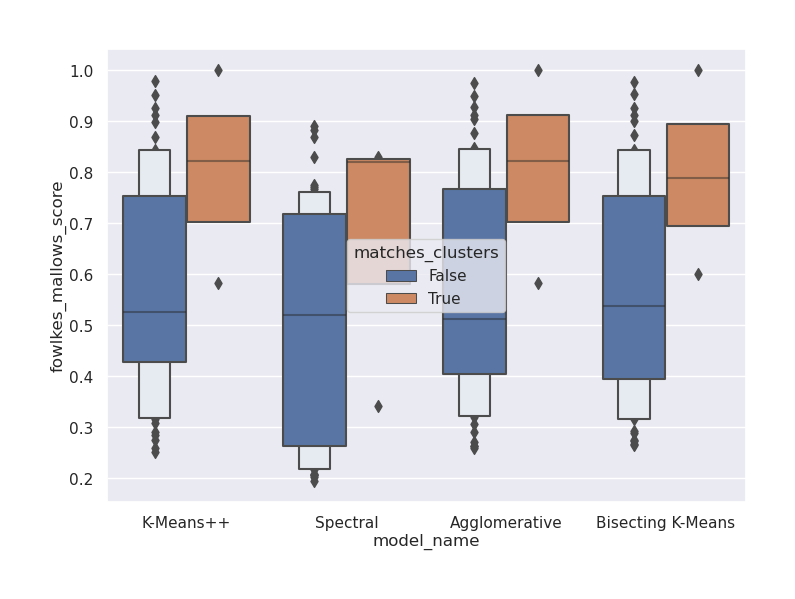

In [66]:
sns.boxenplot(data=results_df, x='model_name', y='fowlkes_mallows_score', hue='matches_clusters')

<AxesSubplot:xlabel='model_name', ylabel='davies_bouldin_score'>

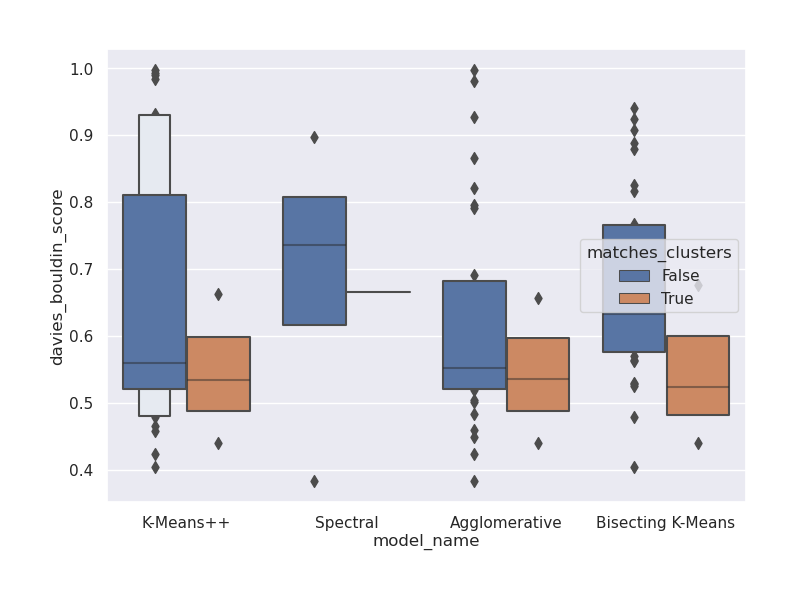

In [67]:
sns.boxenplot(data=results_df[results_df['davies_bouldin_score'] < 1], x='model_name', y='davies_bouldin_score', hue='matches_clusters')

So while category utility won't always predict the best number of clusters, the other metrics won't either

In [53]:
def compare_metrics(base_df: pd.DataFrame, metric_name: str) -> pd.DataFrame:
    grouped_comparison_df: pd.DataFrame = (base_df.groupby(['model_name', 'dataset_name', 'matches_clusters'], as_index=True)
                                           .aggregate({metric_name: lambda g: g.values.tolist()}, axis=0)
                                           .explode(metric_name, ignore_index=False))
    model_dataset_index: pd.MultiIndex = grouped_comparison_df.index.droplevel('matches_clusters').drop_duplicates()

    comparison_dl: tp.List[tp.Dict[str, tp.Any]] = []

    for model_name, dataset_name in model_dataset_index:
        mismatch_clusters: pd.Series = grouped_comparison_df.loc[(model_name, dataset_name, False), metric_name].copy()
        matched_clusters_metric: float = grouped_comparison_df.loc[(model_name, dataset_name, True), metric_name].values.item()

        num_better_mismatched: int = (mismatch_clusters > matched_clusters_metric).sum()

        # Store the model and dataset
        # The total num's + 1 is for when the clusters matched.
        # num_better is for the number of times the model got a better metric with the wrong number of clusters than
        # the metric with the correct number of clusters.
        comparison_dl.append({'model': model_name, 'dataset': dataset_name, 'total_num': mismatch_clusters.size + 1, 'num_better': num_better_mismatched})

    comparison_df: pd.DataFrame = pd.DataFrame.from_records(comparison_dl)
    return comparison_df

In [54]:
results_df

,model_name,dataset_name,num_clusters,true_num_clusters,fowlkes_mallows_score,davies_bouldin_score,category_utility,matches_clusters
0,K-Means++,Wine,2,3,0.659051,0.478784,0.070879,False
1,K-Means++,Wine,3,3,0.583537,0.534243,0.050983,True
2,K-Means++,Wine,4,3,0.516389,0.544401,0.043712,False
3,K-Means++,Wine,5,3,0.508708,0.545047,0.037230,False
4,K-Means++,Wine,6,3,0.491180,0.465807,0.033530,False
...,...,...,...,...,...,...,...,...
211,Bisecting K-Means,Blobs,15,10,0.872394,1.692502,0.176665,False
212,Bisecting K-Means,Blobs,16,10,0.843921,1.858522,0.165894,False
213,Bisecting K-Means,Blobs,17,10,0.813559,1.968460,0.156507,False
214,Bisecting K-Means,Blobs,18,10,0.786554,2.032598,0.148226,False


In [60]:
category_utility_comparison_df: pd.DataFrame = compare_metrics(results_df, 'category_utility')
# : db_score,
fowlkes_mallows_comparison_df: pd.DataFrame = compare_metrics(results_df, 'fowlkes_mallows_score')
davies_bouldin_comparison_df: pd.DataFrame = compare_metrics(results_df, 'davies_bouldin_score')
davies_bouldin_comparison_df['num_better'] = davies_bouldin_comparison_df['total_num'] - davies_bouldin_comparison_df['num_better']

<AxesSubplot:xlabel='model', ylabel='num_better'>

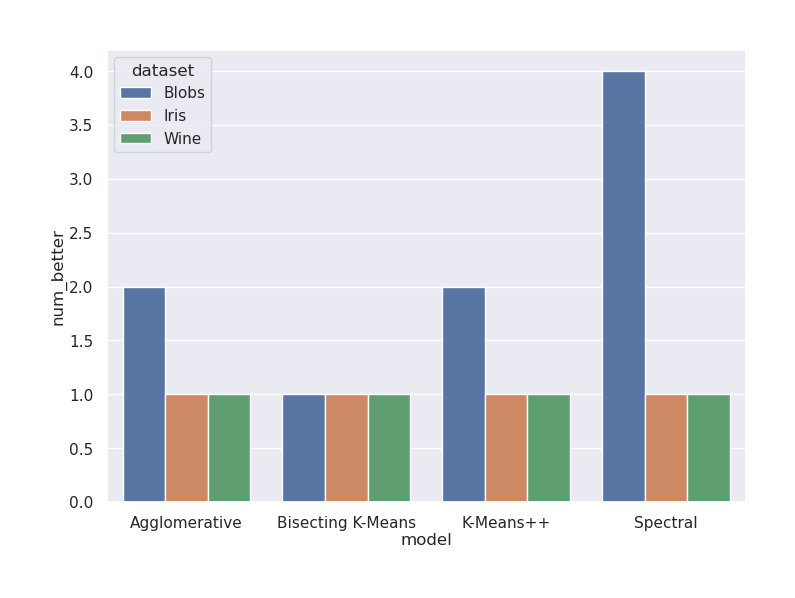

In [68]:
sns.barplot(data=category_utility_comparison_df, x='model', y='num_better', hue='dataset')

<AxesSubplot:xlabel='model', ylabel='num_better'>

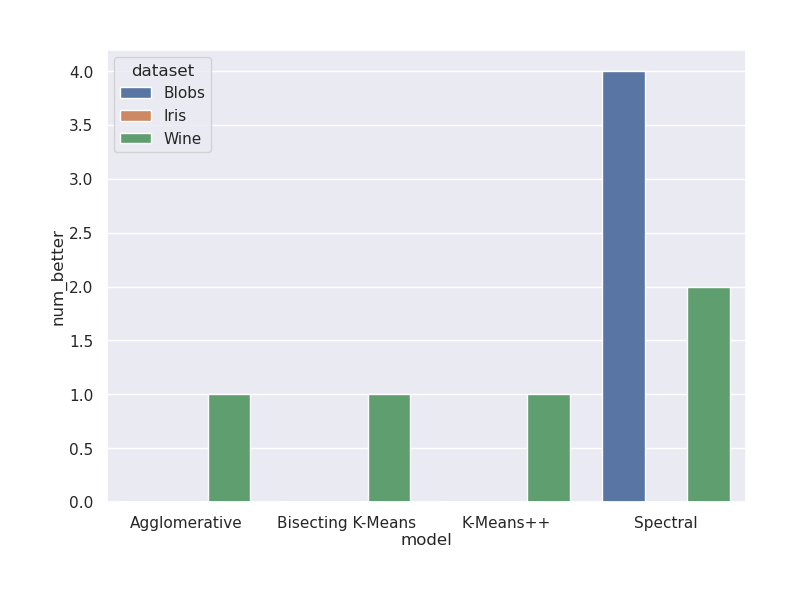

In [69]:
# Measures how close the prediction is to the truth data.
sns.barplot(data=fowlkes_mallows_comparison_df, x='model', y='num_better', hue='dataset')

<AxesSubplot:xlabel='model', ylabel='num_better'>

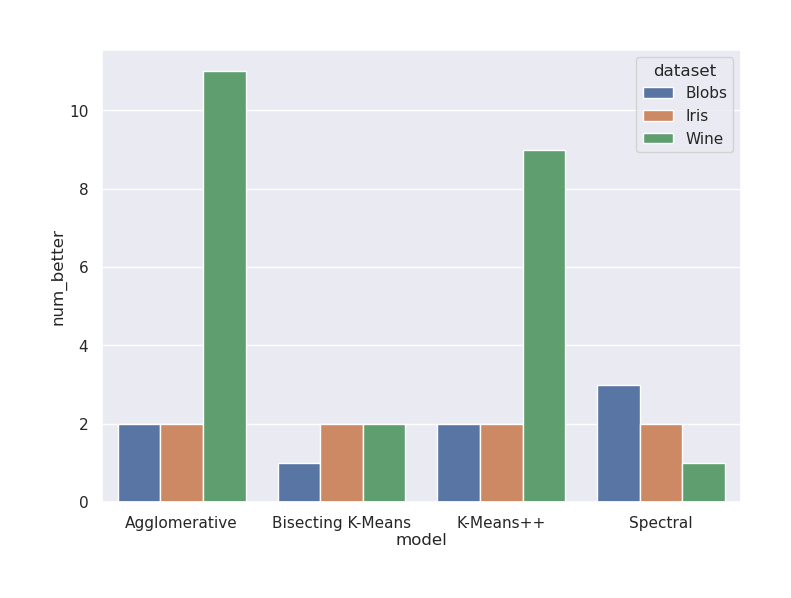

In [70]:
# Davies-Bouldin measures the classic clustering goal -
# everything within a cluster tightly knit and all of them are
# separated from each other.
sns.barplot(data=davies_bouldin_comparison_df, x='model', y='num_better', hue='dataset')